[Google Colaboratory Variant](https://colab.research.google.com/drive/1uB1PuT_uNGM2tv88ZDkIj6Dhi_Rf91PA)

In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#ff55ee; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np
import tensorflow_hub as th,tensorflow as tf
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
from tensorflow.keras.models import Sequential
import h5py,imageio,os,torch,pylab as pl
from keras.preprocessing import image as kimage
from tqdm import tqdm
from PIL import ImageFile,Image
ImageFile.LOAD_TRUNCATED_IMAGES=True
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf
import torch.nn as tnn
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")
from IPython.core.magic import register_line_magic

In [4]:
def path_to_tensor(img_path,fpath,img_size):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(img_size,img_size))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath,img_size):
    tensor_list=[path_to_tensor(img_path,fpath,img_size) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)

In [5]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,3)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=names[labels[i].item()])
            ax.imshow(np.transpose(images[i],(1,2,0)))
        break
@register_line_magic
def display_predict(data):
    if data=='test': x=x_test; y=y_test
    if data=='valid': x=x_valid; y=y_valid 
    kmodel.load_weights(fw)
    y_predict=np.argmax(kmodel.predict(x),axis=-1)
    fig=pl.figure(figsize=(10,8))
    randch=np.random.choice(x.shape[0],
                            size=6,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
        ax.imshow(np.squeeze(x[idx]))
        pred_idx=y_predict[idx]
        true_idx=y[idx]
        ax.set_title("{} \n({})".format(names[pred_idx],
                                      names[true_idx]),
                     color=("#ff55ee" if pred_idx==true_idx 
                            else "darkred"))
    pl.show()

In [6]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples
def history_plot(fit_history):
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#ff55ee',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#ff55ee',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

In [7]:
class HorseBreedsData(tds):
    def __init__(self,csv_path,img_dir,transform=None):
        df=pd.read_csv(csv_path,index_col=0)
        self.img_dir=img_dir
        self.csv_path=csv_path
        self.img_paths=df['path']
        self.y=df['label'].values
        self.transform=transform
    def __getitem__(self,index):
        img=Image.open(os.path\
        .join(self.img_dir,self.img_paths[index]))
        img=img.convert('RGB')
        if self.transform is not None:
            img=self.transform(img)
        lbl=self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [8]:
dhtml('Data Loaders')

In [9]:
img_size=160
fpath='../input/horse-breeds/'
names=['Akhal-Teke','Appaloosa','Orlov Trotter',
       'Vladimir Heavy Draft','Percheron',
       'Arabian','Friesian']
flist=sorted(os.listdir(fpath))
labels=np.array([int(el[:2]) for el in flist],
                dtype='int8')-1
images=np.array(paths_to_tensor(flist,fpath,img_size),
                dtype='float32')/255
N=labels.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
              [x_train.dtype,x_valid.dtype,x_test.dtype],
              [y_train.shape,y_valid.shape,y_test.shape],
              [y_train.dtype,y_valid.dtype,y_test.dtype]],               
             columns=['train','valid','test'])

100%|██████████| 563/563 [00:08<00:00, 65.11it/s]


,train,valid,test
0,"(451, 160, 160, 3)","(56, 160, 160, 3)","(56, 160, 160, 3)"
1,float32,float32,float32
2,"(451,)","(56,)","(56,)"
3,int8,int8,int8


In [10]:
train_csv='train.csv'
valid_csv='valid_csv'; test_csv='test.csv'
img_path='../input'; img_size2=64
files=[os.path.relpath(os.path.join(dirpath,fn),img_path) \
for (dirpath,dirnames,filenames) in os.walk(img_path) \
for fn in filenames if fn.endswith('.png')]
d={'label':[],'breed':[],'file':[],'path':[]}
for f in files:
    _,fn=f.split('/')
    label=int(fn[:2])-1
    breed=names[label]        
    d['label'].append(label)
    d['breed'].append(breed)
    d['file'].append(fn)
    d['path'].append(f)
df=pd.DataFrame.from_dict(d)
np.random.seed(123)
ids=np.random.rand(len(df))<.8
df_train=df[ids]; df_test=df[~ids]
df_train.set_index('file',inplace=True)
df_train.to_csv(train_csv)
df_test.set_index('file',inplace=True)
df_test[:df_test.shape[0]//2].to_csv(test_csv)
df_test[df_test.shape[0]//2:].to_csv(valid_csv)
num_classes=np.unique(df['label'].values).shape[0]
print([num_classes,len(files)]); df_test.head()

[7, 563]


,label,breed,path
file,,,
01_032.png,0,Akhal-Teke,horse-breeds/01_032.png
06_026.png,5,Arabian,horse-breeds/06_026.png
02_063.png,1,Appaloosa,horse-breeds/02_063.png
03_047.png,2,Orlov Trotter,horse-breeds/03_047.png
07_002.png,6,Friesian,horse-breeds/07_002.png


In [11]:
batch_size=16; num_workers=4; grayscale=False
trans=transforms\
.Compose([transforms.Resize((img_size2,img_size2)),
          transforms.ToTensor()])
train=HorseBreedsData(csv_path=train_csv,
                      img_dir=img_path,
                      transform=trans)
test=HorseBreedsData(csv_path=test_csv,
                     img_dir=img_path,
                     transform=trans)
valid=HorseBreedsData(csv_path=valid_csv,
                     img_dir=img_path,
                     transform=trans)
dataloaders={'train':tdl(dataset=train,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers),
             'test':tdl(dataset=test,batch_size=batch_size,
                        shuffle=True,num_workers=num_workers),
             'valid':tdl(dataset=valid,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers)}

Image dimensions: torch.Size([16, 3, 64, 64])
Label dimensions: torch.Size([16])


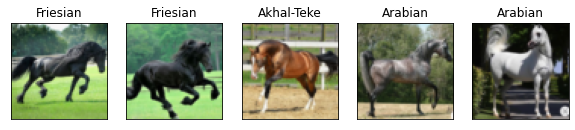

In [12]:
%display_examples valid

In [13]:
dhtml('Classifiers')

In [14]:
fw='weights.best.hdf5'
def premodel(pix,den,mh,lbl,activ,loss):
    model=Sequential([
        tkl.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',
                  metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                     patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(filepath=fw,
                                     save_best_only=True,verbose=2)
    lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [15]:
handle_base="mobilenet_v2_100_160"
mhandle="https://tfhub.dev/google/imagenet/{}/classification/4"\
.format(handle_base)

In [16]:
kmodel=premodel(img_size,2048,mhandle,7,
                'softmax','sparse_categorical_crossentropy')
history=kmodel.fit(x=x_train,y=y_train,batch_size=16,
                   epochs=50,callbacks=cb(fw),
                   validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2052096   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 5,606,704
Trainable params: 5,572,592
Non-trainable params: 34,112
_________________________________________________________________


None

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 2.2400 - accuracy: 0.5055
Epoch 00001: val_loss improved from inf to 14.98842, saving model to weights.best.hdf5
29/29 [==============================] - 3s 119ms/step - loss: 2.2400 - accuracy: 0.5055 - val_loss: 14.9884 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 2/50
28/29 [===========================>..] - ETA: 0s - loss: 1.6777 - accuracy: 0.6674
Epoch 00002: val_loss did not improve from 14.98842
29/29 [==============================] - 2s 55ms/step - loss: 1.7214 - accuracy: 0.6674 - val_loss: 44.5706 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 3/50
28/29 [===========================>..] - ETA: 0s - loss: 1.1150 - accuracy: 0.7143
Epoch 00003: val_loss did not improve from 14.98842
29/29 [==============================] - 2s 53ms/step - loss: 1.1477 - accuracy: 0.7095 - val_loss: 41.1275 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 4/50
28/29 [===========================>..] - ETA: 0s - loss: 1.1796 - accuracy: 0.7545


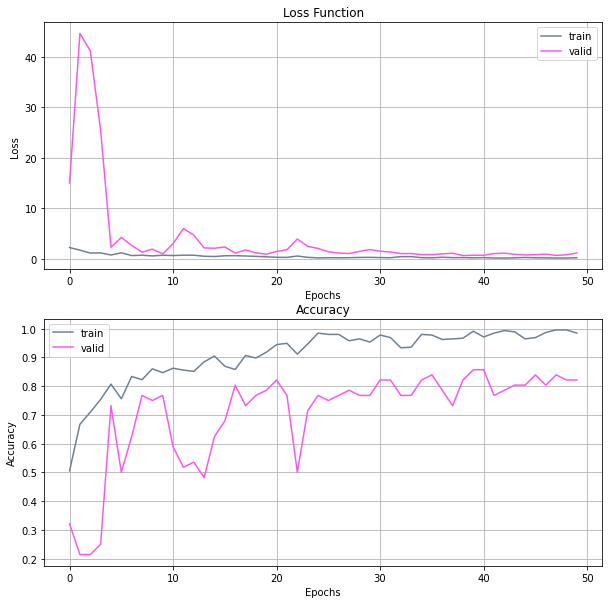

In [17]:
history_plot(history)

In [18]:
kmodel.load_weights(fw)
kmodel.evaluate(x_test,y_test)

2/2 [==============================] - 0s 62ms/step - loss: 1.6561 - accuracy: 0.7143


[1.6560951471328735, 0.7142857313156128]

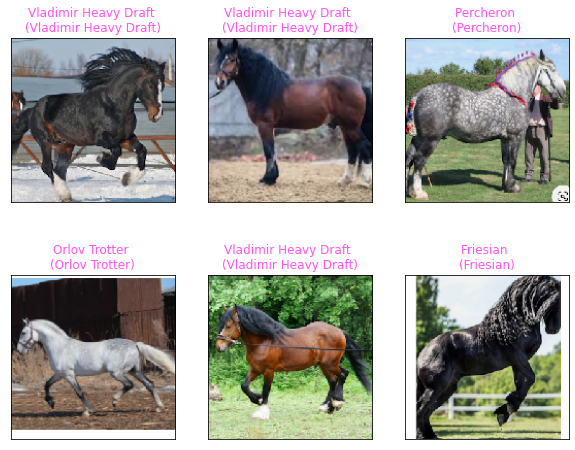

In [19]:
%display_predict test

In [20]:
def kmodel(leaky_alpha):
    model=Sequential()
    model.add(tkl.Conv2D(32,(5,5),padding='same', 
                         input_shape=x_train.shape[1:]))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(196,(5,5)))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))   
    model.add(tkl.GlobalMaxPooling2D())     
    model.add(tkl.Dense(1024))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))
    model.add(tkl.Dropout(.25))     
    model.add(tkl.Dense(7))
    model.add(tkl.Activation('softmax'))   
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
kmodel=kmodel(.02)

In [21]:
history=kmodel.fit(x_train,y_train,epochs=100,
                   batch_size=64,verbose=2,
                   validation_data=(x_valid,y_valid),
                   callbacks=cb(fw))

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.93129, saving model to weights.best.hdf5
8/8 - 1s - loss: 1.9224 - accuracy: 0.2151 - val_loss: 1.9313 - val_accuracy: 0.2321 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_loss improved from 1.93129 to 1.89925, saving model to weights.best.hdf5
8/8 - 0s - loss: 1.8833 - accuracy: 0.1685 - val_loss: 1.8992 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_loss improved from 1.89925 to 1.87193, saving model to weights.best.hdf5
8/8 - 1s - loss: 1.8610 - accuracy: 0.2217 - val_loss: 1.8719 - val_accuracy: 0.2321 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_loss did not improve from 1.87193
8/8 - 0s - loss: 1.8286 - accuracy: 0.2528 - val_loss: 1.9637 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_loss did not improve from 1.87193
8/8 - 0s - loss: 1.8020 - accuracy: 0.2417 - val_loss: 1.9015 - val_accuracy: 0.1964 - lr: 0.0010
Epoch 6/100

Epoch 00006: val_loss improved from 1.87193 to 1.83051, saving m

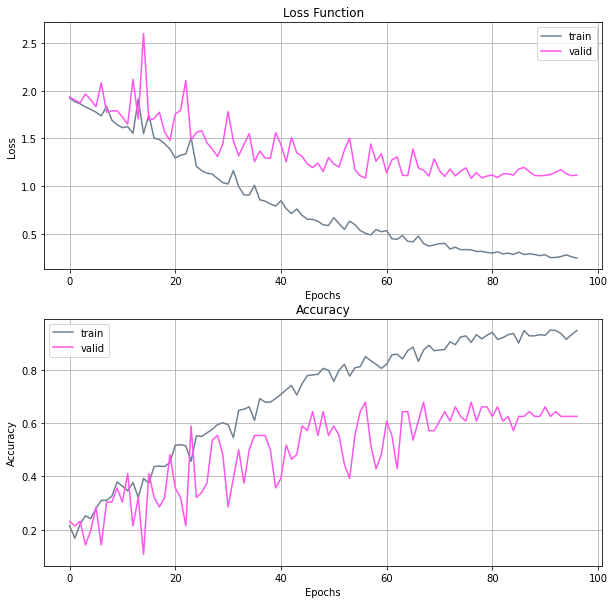

In [22]:
history_plot(history)

In [23]:
kmodel.load_weights(fw)
kmodel.evaluate(x_test,y_test)

2/2 [==============================] - 0s 37ms/step - loss: 1.3425 - accuracy: 0.5000


[1.3424842357635498, 0.5]

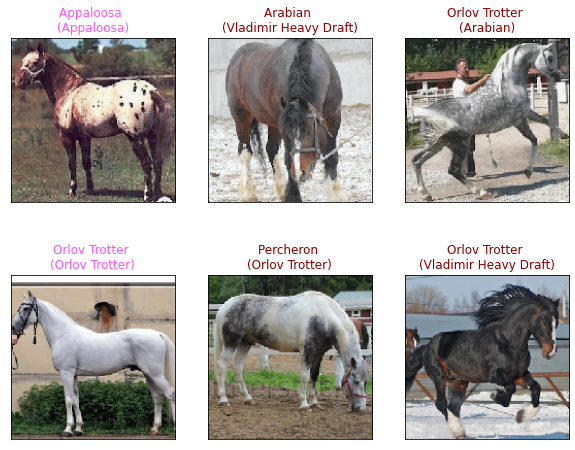

In [24]:
%display_predict test

In [25]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters():
    param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%10:
                print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids,
                         len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d'%(epoch+1,epochs))
            print('train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))

In [27]:
num_classes=7
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

In [28]:
%train_run 25

Epoch: 001/025 | Batch: 000/029 | Cost: 1.9421
Epoch: 001/025 | Batch: 010/029 | Cost: 1.2332
Epoch: 001/025 | Batch: 020/029 | Cost: 1.9904
Epoch: 001/025
train acc/loss: 61.89%/1.06 valid acc/loss: 54.55%/1.35
Epoch: 002/025 | Batch: 000/029 | Cost: 1.2913
Epoch: 002/025 | Batch: 010/029 | Cost: 1.9950
Epoch: 002/025 | Batch: 020/029 | Cost: 0.9697
Epoch: 002/025
train acc/loss: 66.52%/0.94 valid acc/loss: 50.91%/1.26
Epoch: 003/025 | Batch: 000/029 | Cost: 0.7904
Epoch: 003/025 | Batch: 010/029 | Cost: 0.9333
Epoch: 003/025 | Batch: 020/029 | Cost: 0.7401
Epoch: 003/025
train acc/loss: 72.25%/0.81 valid acc/loss: 54.55%/1.17
Epoch: 004/025 | Batch: 000/029 | Cost: 1.1352
Epoch: 004/025 | Batch: 010/029 | Cost: 0.8994
Epoch: 004/025 | Batch: 020/029 | Cost: 1.1905
Epoch: 004/025
train acc/loss: 76.87%/0.70 valid acc/loss: 50.91%/1.26
Epoch: 005/025 | Batch: 000/029 | Cost: 0.9364
Epoch: 005/025 | Batch: 010/029 | Cost: 1.1145
Epoch: 005/025 | Batch: 020/029 | Cost: 1.4630
Epoch: 005/

In [29]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% || test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 97.80% || test acc: 59.26%


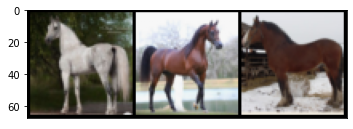


true labels:         Orlov Trotter             ArabianVladimir Heavy Draft

predictions:         Orlov TrotterVladimir Heavy DraftVladimir Heavy Draft


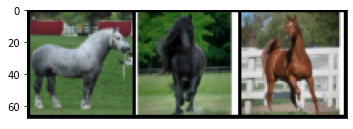


true labels:             Percheron            Friesian             Arabian

predictions:               Arabian            Friesian             Arabian


In [30]:
def show_image(img):
    npimg=img.numpy(); tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders['test']):
        show_image(utils.make_grid(images[:3]))
        print('\ntrue labels: ',
              ''.join('%20s'%names[labels[j]] 
                       for j in range(3)))
        images=images.to(dev)
        labels=labels.to(dev)
        outputs=tmodel(images)
        _,preds=torch.max(outputs,int(1))
        print('\npredictions: ',
             ''.join('%20s'%names[preds[j]]
                      for j in range(3)))
        if i==1: break